Base Graph Manager and convolutional graphs

Perhaps the easiest way to alter the algorithm in dtm-replication beyond just changing hyperparameters is by creating a new base graph manager. A base graph manager manages the non-trivial part of each diffusion step's graph, which is how the hidden nodes and output data nodes connect together (Input nodes are only ever connected to the corresponding output nodes with coupling weights), as well as how the pixel and label data is mapped to the input and output data nodes. Each base graph method must implement a make_base_graph() method which returns nodes, edges, and base graph blocks to be used by the DiffusionStepGraph and sampling specs for each DiffusionStep, as well as 5 other methods for converting data to arrays for blocks and vice versa.

This notebook will illustrate how a new base graph manager can be made by creating what is abusively called a convolutional graph, as it connects image nodes by given image_jumps in image pixel space, and then discuss these convolutional graphs.

In [1]:
from __future__ import annotations
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
from jaxtyping import Array

from thrmlDenoising.annealing_graph_ising import IsingNode
from thrml.block_management import Block
from thrmlDenoising.pgm_continued import Edge
from thrmlDenoising.base_graphs.abstract_base_graph_manager import AbstractBaseGraphManager


# --------------------------- small helpers (self-contained) ---------------------------

def _checkerboard_image_indices(n_image_pixels: int) -> tuple[Array, Array]:
    """
    Return (upper_pixels, lower_pixels) as row-major pixel indices split by (i+j)%2 parity.
    Upper: parity==0, Lower: parity==1. Works for any square number of pixels.
    """
    side = int(np.sqrt(n_image_pixels))
    assert side * side == n_image_pixels, f"n_image_pixels={n_image_pixels} must be a perfect square"
    idx = jnp.arange(n_image_pixels, dtype=jnp.int32)
    i, j = idx // side, idx % side
    upper_mask = ((i + j) % 2) == 0
    upper = jnp.nonzero(upper_mask, size=int(upper_mask.sum()), fill_value=-1)[0]
    lower = jnp.nonzero(~upper_mask, size=int((~upper_mask).sum()), fill_value=-1)[0]
    return upper, lower


# --------------------------- the simplified convolutional manager ---------------------------

class ConvolutionalBinarizedGraphManager(AbstractBaseGraphManager):
    """
    Convolutional base graph manager (teaching version, **binary images only**).

    ## Core ideas
    - **Binary images only**: `n_trials == 1`. Each pixel is one Ising node (no multi-trial encoding).
    - **Convolutional edges in image space**: Given `image_jumps`, each image pixel connects
      to its neighbors via all 4 rotations of each (dx, dy): (dx,dy), (-dy,dx), (-dx,-dy), (dy,-dx).
      **We require dx+dy to be odd** so (row+col) parity flips, ensuring edges cross the bipartition.
    - **Random placement on a bipartite base grid**: Pixels labeled "upper" (by image parity) are
      randomly placed onto the upper half of the base grid; "lower" pixels onto the lower half.
      Label nodes are split ~half/half and also randomly placed within their halves.
    - **No intra-block edges**: Image blocks are [upper_img_block, lower_img_block], label blocks
      [upper_lab_block, lower_lab_block], hidden blocks [upper_hidden, lower_hidden]. All edges
      (base-grid + image-neighborhood) go **upper<->lower**, so no block contains connected nodes.

    ## Why this is “convolutional”
    The “convolution” name is informal: we wire *local* pixel neighborhoods by jumps specified in
    **image space**, but **embed** those pixels randomly in the **base grid**. This lets you change
    local image connectivity independently from how the sampler fans connections across a large,
    sparse, bipartite base graph.

    ## Public attributes
    - `n_bits_per_pixel`: fixed to 1 (binary).
    - `upper_block_to_image_data`, `lower_block_to_image_data`: arrays that map positions in the
       two image output blocks back to canonical row-major pixel indices. These define the **block
       ordering** used in all encode/decode helpers.
    """

    n_bits_per_pixel: int
    upper_block_to_image_data: Array
    lower_block_to_image_data: Array

    def __init__(self, n_image_pixels: int, n_label_nodes: int, n_trials: int):
        """
        **General contract:** set up block lengths and any fixed mappings used by your
        encode/decode functions. Avoid mutating eqx.Modules later—precompute mappings here.

        **This manager:** assert binary; split image pixels into two blocks by parity; split
        labels evenly; stash the (block_pos -> pixel_index) arrays.
        """
        assert n_trials == 1, "This teaching manager supports *only* binarized images (n_trials == 1)."
        self.n_bits_per_pixel = 1

        # Image blocks by parity of pixel coordinates (upper parity 0, lower parity 1)
        upper_img_idx, lower_img_idx = _checkerboard_image_indices(n_image_pixels)
        self.upper_block_to_image_data = upper_img_idx
        self.lower_block_to_image_data = lower_img_idx

        n_upper_img = int(upper_img_idx.shape[0])
        n_lower_img = int(lower_img_idx.shape[0])
        image_output_block_lengths = [n_upper_img, n_lower_img]

        # Split labels ~half/half between halves (order: all upper first, then all lower)
        n_upper_lab = n_label_nodes // 2
        n_lower_lab = n_label_nodes - n_upper_lab
        label_output_block_lengths = [n_upper_lab, n_lower_lab]

        super().__init__(n_image_pixels, n_label_nodes, image_output_block_lengths, label_output_block_lengths)

    # --------------------------- encode/decode helpers (5 methods) ---------------------------

    def convert_output_blocks_to_pixels(self, ising_data: list[Array]) -> Array:
        """
        **General contract:** Given the list of image output *blocks* returned by sampling,
        reconstruct the canonical pixel array (last dim == n_image_pixels) in the order the
        rest of the code expects (row-major).

        **This manager:** two image blocks (upper, lower). We write those back into a single
        result via the fixed index maps defined at __init__.
        """
        assert len(ising_data) == 2, f"expected 2 image blocks, got {len(ising_data)}"
        upper_block, lower_block = ising_data

        assert upper_block.shape[-1] == self.upper_block_to_image_data.shape[0]
        assert lower_block.shape[-1] == self.lower_block_to_image_data.shape[0]

        out = jnp.zeros(upper_block.shape[:-1] + (self.n_image_pixels,), dtype=upper_block.dtype)
        out = out.at[..., self.upper_block_to_image_data].set(upper_block)
        out = out.at[..., self.lower_block_to_image_data].set(lower_block)
        return out

    def convert_pixels_to_output_blocks(self, image_data: Array) -> list[Array]:
        """
        **General contract:** Split canonical pixel arrays into the image *output blocks*
        (order must match how you build `Block(image_nodes)` in `make_base_graph`).

        **This manager:** binary images, two blocks (upper, lower) by parity.
        """
        assert image_data.shape[-1] == self.n_image_pixels
        upper_block = image_data[..., self.upper_block_to_image_data]
        lower_block = image_data[..., self.lower_block_to_image_data]
        return [upper_block, lower_block]

    def convert_pixels_and_labels_to_input_block(self, image_data: Array, label_data: Array) -> Array:
        """
        **General contract:** Build a single array for the *input* block (image-then-label),
        in exactly the same node order used to create the conditioning block in DiffusionStep.

        **This manager:** concatenate image upper, image lower, then labels (upper then lower),
        matching how we place nodes in `make_base_graph`.
        """
        assert image_data.shape[-1] == self.n_image_pixels
        assert label_data.shape[-1] == self.n_label_nodes

        img_upper = image_data[..., self.upper_block_to_image_data]
        img_lower = image_data[..., self.lower_block_to_image_data]
        img_part = jnp.concatenate([img_upper, img_lower], axis=-1)

        # Split labels in the same sizes we advertised via label_output_block_lengths
        n_upper_lab, n_lower_lab = self.label_output_block_lengths
        lab_upper = label_data[..., :n_upper_lab]
        lab_lower = label_data[..., n_upper_lab:]
        assert lab_lower.shape[-1] == n_lower_lab

        input_block = jnp.concatenate([img_part, lab_upper, lab_lower], axis=-1)
        expected = self.n_image_pixels + self.n_label_nodes
        assert input_block.shape[-1] == expected, f"{input_block.shape[-1]} != {expected}"
        return input_block

    def convert_label_out_blocks_to_label(self, ising_data: list[Array]) -> Array:
        """
        **General contract:** Merge label *output blocks* back to a single label vector.

        **This manager:** two label blocks: [upper_labels, lower_labels] → concat.
        """
        assert len(ising_data) == 2, "There are two label output blocks (upper, lower)."
        upper_lab, lower_lab = ising_data
        return jnp.concatenate([upper_lab, lower_lab], axis=-1)

    def convert_label_to_label_out_blocks(self, label_data: Array) -> list[Array]:
        """
        **General contract:** Split a label vector into label *output blocks*.

        **This manager:** two blocks sized as in __init__ (upper half then lower half).
        """
        assert label_data.shape[-1] == self.n_label_nodes
        n_upper_lab, n_lower_lab = self.label_output_block_lengths
        upper_lab = label_data[..., :n_upper_lab]
        lower_lab = label_data[..., n_upper_lab:]
        assert lower_lab.shape[-1] == n_lower_lab
        return [upper_lab, lower_lab]

    # --------------------------- graph builder (1 method) ---------------------------

    def make_base_graph(
        self,
        key,
        graph_preset_arch,
        n_image_pixels: int,
        n_label_nodes: int,
        torus: bool = False,
    ):
        """
        **General contract:** Build the *bipartite* base grid (nodes + edges), place image/label
        nodes onto its halves, create hidden nodes for the rest, and return the three families
        of `Block`s in the exact node order your encode/decode helpers assume.

        **This manager (convolutional):**
        1) Load preset: (base_grid_side_len, base-jumps, image-jumps). **Assert every jump has odd dx+dy**.
        2) Create all **base-grid edges** by rotating each base jump into 4 directions; these connect
           upper<->lower on the full grid.
        3) Split the **full grid** by checkerboard parity into (upper_indices, lower_indices).
        4) Randomly place:
             - *upper image pixels* onto upper_indices[:n_upper_img],
             - *lower image pixels* onto lower_indices[:n_lower_img],
             - labels similarly by halves.
        5) Build **image-to-full mapping** following **block order** (upper block order first, then lower).
        6) Add **convolutional edges**: for every image pixel and each image jump (plus its rotations),
           connect that pixel’s base node to its neighbor’s base node (when in-bounds). Because dx+dy is odd,
           these edges also cross the bipartition (upper<->lower) → **no intra-block edges**.
        7) Create `IsingNode`s, carve out `Block`s in the order used by encode/decode methods, and
           dedupe edges with a set.
        """
        if graph_preset_arch not in graph_preset_architectures:
            raise ValueError(f"Unknown preset: {graph_preset_arch}")
        base_grid_side_len, base_jumps, image_jumps = graph_preset_architectures[graph_preset_arch]

        # --- sanity checks ---
        side_img = int(np.sqrt(n_image_pixels))
        assert side_img * side_img == n_image_pixels, "Image size must be a square."

        if torus:
            assert base_grid_side_len % 2 == 0, "Torus requires even base_grid_side_len to keep bipartiteness."

        for dx, dy in base_jumps:
            assert ((dx + dy) % 2) == 1, f"Base jump {(dx,dy)} must have odd dx+dy to connect upper<->lower."
        for dx, dy in image_jumps:
            assert ((dx + dy) % 2) == 1, f"Image jump {(dx,dy)} must have odd dx+dy to connect upper<->lower."

        # --- base grid helpers ---
        size = base_grid_side_len ** 2
        n_lower_nodes = size // 2
        n_upper_nodes = size - n_lower_nodes

        def get_idx(i, j):
            if torus:
                i = (i + 10 * base_grid_side_len) % base_grid_side_len
                j = (j + 10 * base_grid_side_len) % base_grid_side_len
            cond = (i >= base_grid_side_len) | (j >= base_grid_side_len) | (i < 0) | (j < 0)
            return jnp.where(cond, -1, i * base_grid_side_len + j)

        def get_coords(idx):
            return idx // base_grid_side_len, idx % base_grid_side_len

        def make_edge_single(idx, di, dj):
            # Always return (upper_idx, lower_idx) for determinism.
            def upper_node_first(_):
                return jnp.array([idx, get_idx(i + di, j + dj)])
            def lower_node_first(_):
                return jnp.array([get_idx(i + di, j + dj), idx])
            i, j = get_coords(idx)
            upper_first = ((i + j) % 2) == 0
            return lax.cond(upper_first, upper_node_first, lower_node_first, operand=None)

        make_edge_arr = jax.jit(jax.vmap(make_edge_single, in_axes=(0, None, None), out_axes=0))

        # 1) base-grid edges (4 rotations per jump)
        full_indices = jnp.arange(size, dtype=jnp.int32)
        edge_arrs = []
        for dx, dy in base_jumps:
            edge_arrs.append(make_edge_arr(full_indices,  dx,  dy))
            edge_arrs.append(make_edge_arr(full_indices, -dy,  dx))
            edge_arrs.append(make_edge_arr(full_indices, -dx, -dy))
            edge_arrs.append(make_edge_arr(full_indices,  dy, -dx))

        # 2) split full grid into halves by chessboard parity
        i_full = full_indices // base_grid_side_len
        j_full = full_indices %  base_grid_side_len
        upper_mask = ((i_full + j_full) % 2) == 0

        upper_indices = jnp.nonzero(upper_mask, size=int(upper_mask.sum()), fill_value=-1)[0]
        lower_indices = jnp.nonzero(~upper_mask, size=int((~upper_mask).sum()), fill_value=-1)[0]
        assert upper_indices.shape[0] == n_upper_nodes and lower_indices.shape[0] == n_lower_nodes

        # 3) data sizes
        n_upper_img, n_lower_img = self.image_output_block_lengths
        n_upper_lab, n_lower_lab = self.label_output_block_lengths
        n_upper_data = n_upper_img + n_upper_lab
        n_lower_data = n_lower_img + n_lower_lab
        assert n_upper_data < n_upper_nodes, "Upper data must fit in the upper half."
        assert n_lower_data < n_lower_nodes, "Lower data must fit in the lower half."

        # 4) randomly place image/label nodes within halves
        key_u, key_l = jr.split(key, 2)
        upper_perm = jr.permutation(key_u, upper_indices)
        lower_perm = jr.permutation(key_l, lower_indices)

        upper_image_full = upper_perm[:n_upper_img]
        upper_label_full = upper_perm[n_upper_img:n_upper_img + n_upper_lab]
        lower_image_full = lower_perm[:n_lower_img]
        lower_label_full = lower_perm[n_lower_img:n_lower_img + n_lower_lab]

        # 5) build image->full mapping that **matches block order**
        upper_pixels = self.upper_block_to_image_data  # (n_upper_img,)
        lower_pixels = self.lower_block_to_image_data  # (n_lower_img,)
        image_to_full = jnp.full((n_image_pixels,), -1, dtype=jnp.int32)
        if n_upper_img:
            image_to_full = image_to_full.at[upper_pixels].set(upper_image_full)
        if n_lower_img:
            image_to_full = image_to_full.at[lower_pixels].set(lower_image_full)

        # 6) add convolutional (image-space) edges, mapped into full-grid ids
        img_idx = jnp.arange(n_image_pixels, dtype=jnp.int32)

        def get_img_coords(p):
            return p // side_img, p % side_img

        def get_img_idx(ii, jj):
            cond = (ii >= side_img) | (jj >= side_img) | (ii < 0) | (jj < 0)
            return jnp.where(cond, -1, ii * side_img + jj)

        def make_edge_for_image_single(pix, di, dj):
            # Returns (upper_full_idx, lower_full_idx) or (-1, -1) if out-of-bounds.
            i, j = get_img_coords(pix)
            nbr = get_img_idx(i + di, j + dj)

            src_full = image_to_full[pix]
            nbr_full = lax.cond(nbr == -1, lambda _: jnp.int32(-1), lambda _: image_to_full[nbr], operand=None)

            # Keep upper endpoint first by image parity. (Odd jumps guarantee opposite parity.)
            upper_first = ((i + j) % 2) == 0
            return lax.cond(
                upper_first,
                lambda _: jnp.array([src_full, nbr_full]),
                lambda _: jnp.array([nbr_full, src_full]),
                operand=None,
            )

        make_edge_arr_img = jax.jit(jax.vmap(make_edge_for_image_single, in_axes=(0, None, None), out_axes=0))

        for dx, dy in image_jumps:
            edge_arrs.append(make_edge_arr_img(img_idx,  dx,  dy))
            edge_arrs.append(make_edge_arr_img(img_idx, -dy,  dx))
            edge_arrs.append(make_edge_arr_img(img_idx, -dx, -dy))
            edge_arrs.append(make_edge_arr_img(img_idx,  dy, -dx))

        # 7) instantiate nodes, carve blocks, dedupe edges
        all_nodes: list[IsingNode] = [IsingNode() for _ in range(size)]

        # Image nodes in **block order** (upper block first, then lower block)
        upper_image_nodes = [all_nodes[int(image_to_full[int(p)])] for p in np.asarray(upper_pixels)]
        lower_image_nodes = [all_nodes[int(image_to_full[int(p)])] for p in np.asarray(lower_pixels)]
        image_output_nodes = upper_image_nodes + lower_image_nodes

        # Label nodes: keep "upper labels then lower labels" ordering
        upper_label_nodes = [all_nodes[int(i)] for i in np.asarray(upper_label_full)]
        lower_label_nodes = [all_nodes[int(i)] for i in np.asarray(lower_label_full)]
        label_output_nodes = upper_label_nodes + lower_label_nodes

        # Hidden nodes are whatever remains in each half
        used_upper = set(np.asarray(jnp.concatenate([upper_image_full, upper_label_full]), dtype=int).tolist())
        used_lower = set(np.asarray(jnp.concatenate([lower_image_full, lower_label_full]), dtype=int).tolist())
        upper_hidden_nodes = [all_nodes[int(i)] for i in np.asarray(upper_indices) if int(i) not in used_upper]
        lower_hidden_nodes = [all_nodes[int(i)] for i in np.asarray(lower_indices) if int(i) not in used_lower]
        hidden_nodes = upper_hidden_nodes + lower_hidden_nodes

        # Build unique Edge objects
        edge_array = np.concatenate(edge_arrs, axis=0)
        expected_rows = 4 * len(base_jumps) * size + 4 * len(image_jumps) * n_image_pixels
        assert edge_array.shape == (expected_rows, 2)

        grid_edges: list[Edge] = []
        seen = set()
        for u_idx, v_idx in edge_array:
            if (u_idx == -1) or (v_idx == -1):
                continue
            u_node = all_nodes[int(u_idx)]
            v_node = all_nodes[int(v_idx)]
            e = Edge((u_node, v_node))
            if e in seen:
                continue
            seen.add(e)
            grid_edges.append(e)

        # Blocks: **no intra-block edges** by construction (all edges go upper<->lower)
        image_output_blocks = [Block(upper_image_nodes), Block(lower_image_nodes)]
        label_output_blocks = [Block(upper_label_nodes), Block(lower_label_nodes)]
        hidden_blocks = [Block(upper_hidden_nodes), Block(lower_hidden_nodes)]

        return (
            image_output_nodes,
            label_output_nodes,
            hidden_nodes,
            grid_edges,
            image_output_blocks,
            label_output_blocks,
            hidden_blocks,
        )


# --------------------------- presets: (base_side, base_jumps, image_jumps) ---------------------------
# IMPORTANT: every jump (dx, dy) must have **odd** dx+dy to preserve bipartiteness. The 4 rotations
# are applied automatically, yielding an undirected, upper<->lower edge set.

graph_preset_architectures = {
    # Tiny toy
    4_4_1: (
        4,
        [
            (0, 1)
        ],       # base grid degree ≈ 4 (rotations of (0,1))
        [
            (0, 1)
        ],       # image neighborhood = 4-neighborhood
    ),
    # Medium/high degree grid, single image neighborhood
    60_12_1: (
        60,
        [
            (0, 1),
            (4, 1),
            (10, 9),
        ],               # 3 rules => 12 oriented base edges per node in the interior (on torus)
        [
            (0, 1)
        ],        # 4-neighborhood in image space
    ),
}

We can test this new manager on smoke test data:

In [3]:
from thrmlDenoising.DTM import DTM
from thrmlDenoising.utils import make_cfg
from thrmlDenoising.smoke_testing import compute_conditional_accuracy, compute_free_accuracy, save_accuracy_plot
import jax.random as jr

def smoke_cfg(seed, descriptor, num_steps=1):
    return make_cfg(
        exp=dict(seed=seed, descriptor=descriptor, compute_autocorr=False, generate_gif=False),
        data=dict(dataset_name="smoke_testing_4_1_4"),
        graph=dict(graph_preset_architecture=4_4_1, num_label_spots=2, grayscale_levels=1, torus=False, base_graph_manager=ConvolutionalBinarizedGraphManager),
        sampling=dict(n_samples=10, steps_per_sample=5, steps_warmup=40, training_beta=1.0),
        generation=dict(generation_beta_start=0.8, generation_beta_end=1.2, steps_warmup=60, fid_images_per_digit=50),
        diffusion_schedule=dict(num_diffusion_steps=num_steps, kind="log", diffusion_offset=0.1),
        diffusion_rates=dict(image_rate=0.8, label_rate=0.2),
        optim=dict(momentum=0.9, b2_adam=0.999, step_learning_rates=(0.1,), n_epochs_for_lrd=10),
        cp=dict(adaptive_cp=False),
    ) # target classes and batch size are automatically handled for smoke testing
n_epochs = 150
# Train a single DTM, saving checkpoints along the way
cfg = smoke_cfg(1, "smoke_frank")
dtm = DTM(cfg)
dtm.train(n_epochs, 50)

Configuration:
{ 'cp': { 'adaptive_cp': False,
          'adaptive_threshold': 0.016,
          'correlation_penalty': (0.0,),
          'cp_min': 0.001},
  'data': { 'dataset_name': 'smoke_testing_4_1_4',
            'pixel_threshold_for_single_trials': 0.1,
            'target_classes': (0, 1, 2, 3)},
  'diffusion_rates': {'image_rate': 0.8, 'label_rate': 0.2},
  'diffusion_schedule': { 'diffusion_offset': 0.1,
                          'kind': 'log',
                          'num_diffusion_steps': 1},
  'exp': { 'animated_images_per_digit': 2,
           'compute_autocorr': False,
           'descriptor': 'smoke_frank',
           'drawn_images_per_digit': 4,
           'generate_gif': False,
           'graph_seeds': (1,),
           'n_cores': 1,
           'seed': 1,
           'steps_per_sample_in_gif': 10},
  'generation': { 'fid_images_per_digit': 50,
                  'generation_beta_end': 1.2,
                  'generation_beta_start': 0.8,
                  'steps_warmup'

But of course the convolutional manager will not help more than another manager unless the smoke data is locally correlated.

While this example convolutional manager only handles a single grayscale level, the ConvolvedPoissonBinomialIsingGraphManager in base graphs is setup to run on arbitrary grayscale levels, by connecting the kth node of pixel A to the kth node of pixel B. We briefly discuss the differences in behaviour between the convolutional manager (ConvolvedPoissonBinomialIsingGraphManager) and non-convolutional counterpart (PoissonBinomialIsingGraphManager) in the remainder of this notebook.

Generally a convolutional manager is able to perform better than a graph with only random edges, but not by very large margins. Here we show a MEBM 70_40 random edge graph in comparison to an MEBM ConvolvedPoissonBinomialIsingGraphManager 70_36_1 graph (where we add the extra 4 edges to the random edge as a single convolutional edge rule adds 4 edges to each node.) 

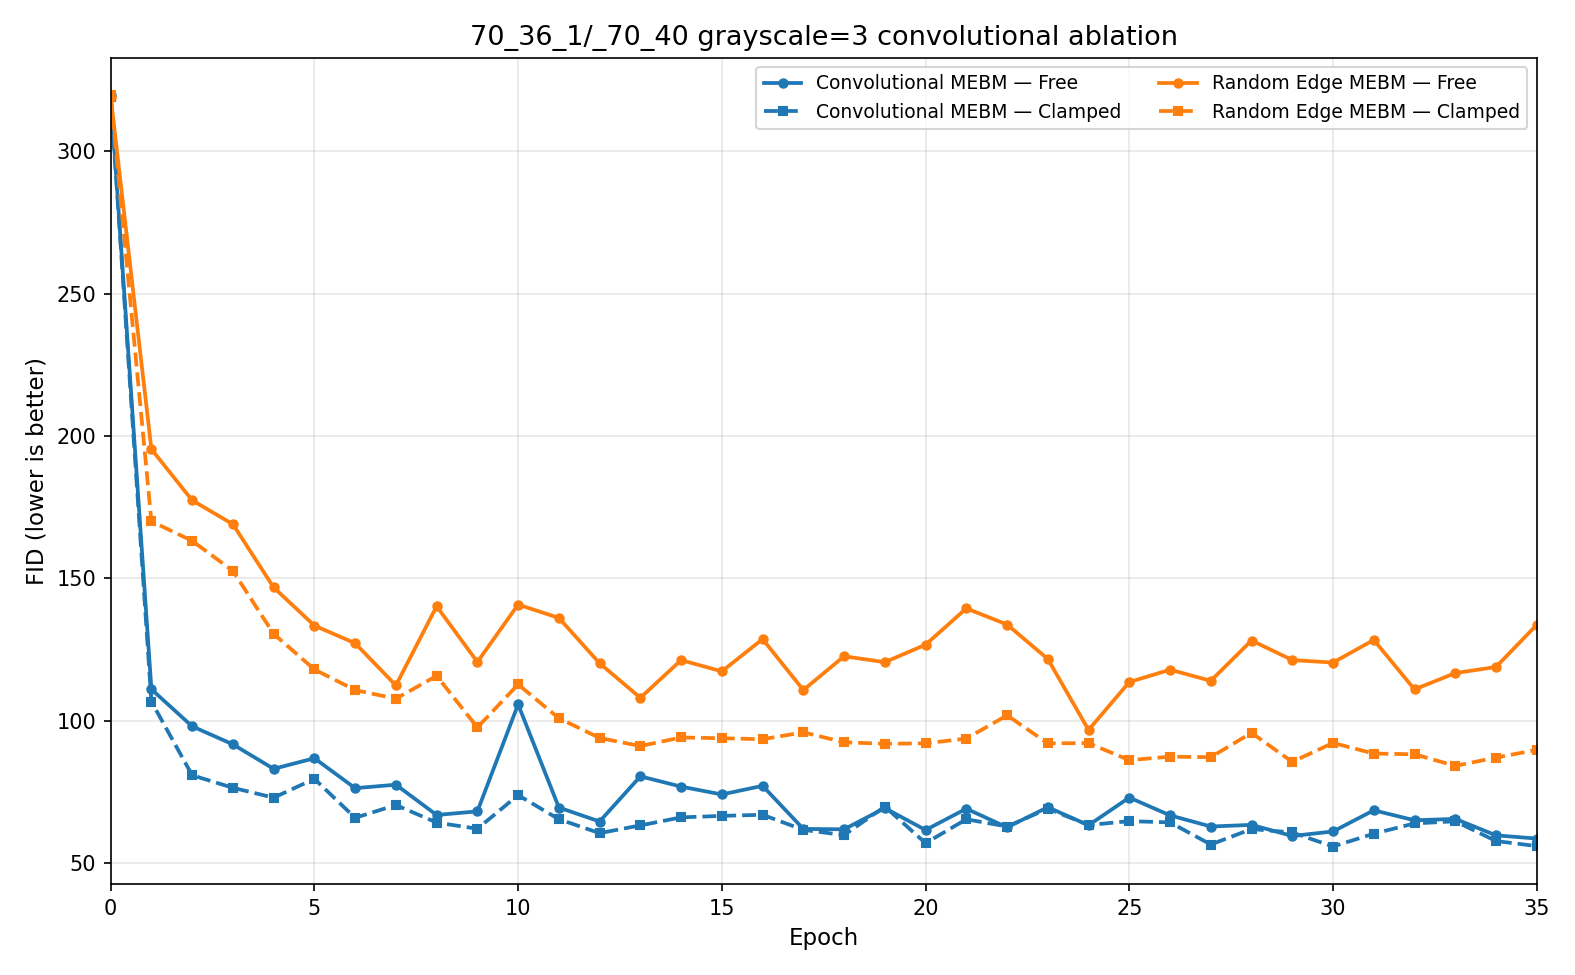

This setup makes the convolutional gains a bit more extreme than they always are. 

It also seems that compared to traditional random edge graphs, convolutional ones tend to have a lower mixing time.

Here are the same two 70_36_1/70_40 MEBMs which trained with a training schedule of 400 warmup steps, 8 steps per sample with 50 samples, as well as 2 additional models, one with a convolutional graph one with a random edge graph, but both trained on a 200/4/50 schedule.

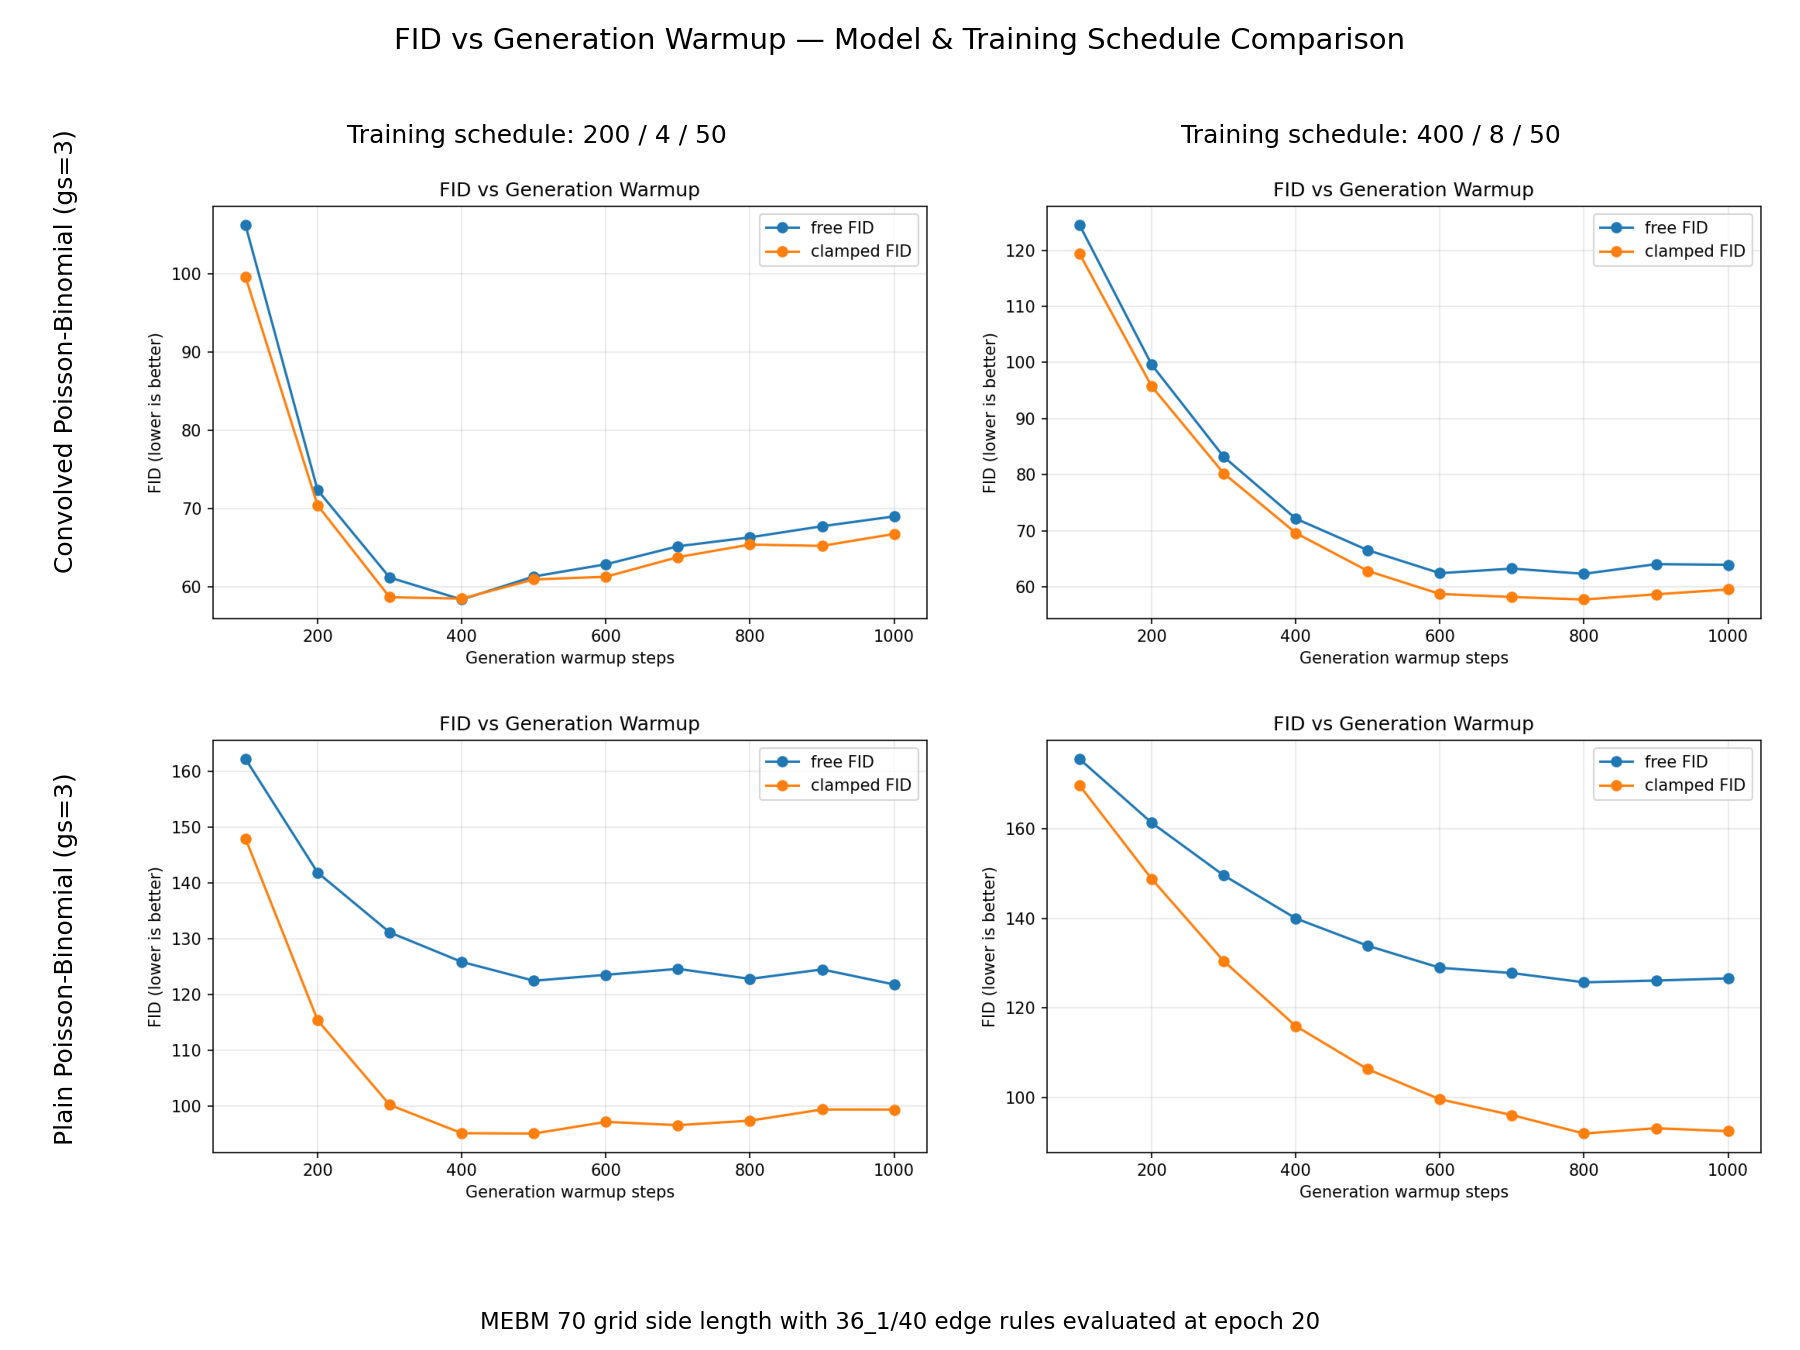

The upward slope on the later part of the graph in the upper right 200/4/50 convolutional graph MEBM is interesting because it might suggest training is not shaping the equilibrium distribution but something out of equilibrium.